In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

### Dynamic Topic Modelling
Change is important for businesses to hold a competitive edge and to meet the ever-changing needs of customers. Netflix and General Electric are two examples of companies that have evolved to adapt to the fast-moving trends of their respective industry. On the other hand, businesses like Blockbuster and MySpace failed to innovate and adapt to the moving trends. Investors often spend a great deal of time reading through financial reports to detect signs of change and adaption, so our work systematically summarises the business model of a company over time. 

In this section, we apply several topic modeling techniques to the Business description of filings between the years 2016 and 2018 to detect differences and emerging themes within a company. By finding these differences, we can see how the company has evolved over the years and understand shifts in the operation of the company. More specifically, we explored Non-Negative Matrix Factorization (NMF), Latent Dirichlet Allocation (LDA), and Latent Semantic Analysis (LSA) for topic modeling.

We use Netflix (NTFL) and General Electric (GE) as Proof of Concept to test our topic models since they are companies that have evolved drastically over the past 15 years.

##### Netflix
Netflix was founded by Reed Hastings and Marc Rudolph in 1997 as a DVD rental-by-mail business. A year later, Netflix introduced a subscription model where customers could rent DVDs online for a fixed fee per month. In 2007, it entered the market of video streaming where anyone could enjoy live streaming videos on their computer for a monthly subscription fee. Around this time, the world was getting accustomed to the internet and technology was advancing rapidly. In 2009, the company began partnering with electronic companies to get Netflix on multiple devices like smart TVs and gaming consoles. This move attracted audiences with different background profiles and pushed Netflix to the top of the video-streaming industry. In 2011, Netflix introduced its mobile apps and ios service for smartphone users.

Throughout the years, Netflix stayed competitive by changing its business strategy with the advancement of technology and catering to changing customer needs.


##### General Electric
General Electric (GE) was founded in 1892 and currently operates through eight industrial segments: Aviation, Healthcare, Transportation, Renewable Energy, Oil & Gas, Appliances & Lighting, Power & Water, and Capital. GE Aviation is GE's most profitable division. It made steps forward in recent years, namely in 2007 by acquiring Smith Aerospace, an American aircraft engine, and aircraft parts manufacturer, and in 2012 by acquiring Avio S.p.A., an Italy-based manufacturer of aviation propulsion components and systems for civil and military aircraft. On the other hand, GE Healthcare had slow growth in the years 2010 to 2015 but saw a significant increase in profits in 2016 by more than 0.3 billion dollars compared to the year before. GE Power & Water, GE Renewable Energy, and GE Oil & Gas were all under GE Energy up until it split in 2012. In 2014, GE Power made moves to purchase French gas turbine company Alstom for $\$$ 13 billion dollars. Unfortunately, this move coincided with a global downturn in the price of renewables, lessening the demand for the gas turbines, and did not bring the profits that GE had hoped for. 2014 was also the year that GE agreed to sell GE Appliances to Electrolux, a Swedish appliance manufacturer and the second-largest consumer appliance manufacturer after Whirlpool Corporation, for $\$$3.3 billion in cash.

In the history of the business, GE suffered through the financial crisis in 2008 and began its downfall. From 2008 to 2017, the company consistently slashed its dividends year over year and laid off thousands of employees across all divisions. However, in 2018, GE made significant improvements in cutting debt and raising capital by selling off subsidiaries. In 2021, GE decided to separate GE HealthCare and GE Power into public companies and focus mainly on GE Aviation. 

In [56]:
## Dynamic Topic Modelling with Netflix, GE
targetComp = pd.read_csv("../data/dynamic_companies.csv")
netflix = targetComp[targetComp["financialEntity"] == "financialEntities/params;cik=1065280"].sort_values(["reportingDate"])
ge = targetComp[targetComp["financialEntity"] == "financialEntities/params;cik=40545"].sort_values(["reportingDate"])

##### Non-Negative Matrix Factorization
Non-negative matrix factorization uses linear algebra to discover underlying relationships between texts. It factorizes/decomposes high-dimensionality vectors(ie. TF-IDF or BOW embeddings) into a lower-dimensional representation. Given an original matrix obtained using TF-IDF or any word embedding algorithm of size MxN where M is the number of documents and N is the number of n-grams, NMF generates the **Feature** matrix and **Components** matrix. The Features matrix represents the weights of topics for each document and the Component matrix represents the weights of words for each topic. NMF modifies the values of the initial Feature matrix and Components matrix so that the product approaches the original matrix until approximation error converges or max iterations are reached (ie. $Original Matrix \approx$ $Features \times Components$). The matrices generated by NMF will only give non-negative values.



NMF is very sensitive to the hyperparameters such as the number of topics, so we can use coherence scores to evaluate the most optimal number of topics so that each topic is human interpretable. The coherence of a topic, used as a proxy for topic quality, is based on the distributional hypothesis that states that words with similar meanings tend to co-occur within a similar context.

A coherence score measures the relative distance between words within a topic. There are several coherence metrics but the most popular one is CV, which is the metric that we will use in our report. CV coherence score creates content vectors of words using their co-occurrences (ie. co-occurrence of "Las" and "Vegas" would be very high) and calculates the score using normalized pointwise mutual information (NPMI) and cosine similarity. CV coherence score is based on three parts: (i) calculation of word or word pair probabilities (i.e. $P(w_i)$ or $P(w_i, w_j)$ (ii) calculation of a confirmation measure using NPMI (iii) aggregation of individual confirmation measures into an overall coherence score.

(i)Probabilities of single words  $P(w_i)$ or the joint probabilizy of two words $P(w_i, w_j)$ can be estimated by Boolean document calculation, that is, the number of documents in which $w_i$ or $(w_i, w_j)$ occurs, divided by the total number of documents.

(ii) The confirmation measure is calculated by using NPMI, which is the likelihood of the co-occurrence of two words, taking into account the fact that it might be caused by the frequency of the single words. 

        1) $NPMI(w_i, w_j) = \frac{log\frac{P(w_i, w_j)+\epsilon}{P(w_i)P(w_j)}}{-log(P(w_i, w_j)+\epsilon)}$

        (2) $\vec{v} = {\sum_{w_i, w_j\in words} {NPMI(w_i, w_j)}} $
 
        (3) $\phi_{s_i}(\vec{u}, \vec{w})  = \frac{ {\sum_{i=1}^{|words|}u_i \cdot w_i}}{{\lVert \vec{u} \rVert}_2 \cdot{\lVert \vec{w} \rVert}_2}$

(iii) We calculate the global coherence of the topic as the arithmetic mean of all confirmation measures $\phi$

We ran the metric over a range of 3 to 40 topics, incrementing by 3, and achieved the result below. Although coherence is highest for 6 topics, we know that there are close to 50 different categories of companies in the dataset and thus 6 topics will not give well-separated results. Therefore, we chose the give our model 18 topics, which has the next highest coherence score, and will not give topics that are too specific to this set of data. If you're interested in the code, see this  [file](https://richardye101.github.io/ubineer_nlp_research/lab?path=mary%2FWeek+10+-+NMF+vs+LDA+vs+LSA.ipynb)

![NMF Coherence](../images/nmf_coherence.png)

The table below illustrates the results produced by the NMF model tuned to generate 18 topics. Each column is a topic identified by the column index and is represented by the top 10 words in the topic by weight. 

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
filtered = pd.read_csv("filtered_timeseries_data.csv")
filtered_data = filtered.loc[:,"coDescription_stopwords"].to_list()
filtered_dates = filtered["reportingDate"].to_list()

tf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=2000) 
filtered_all_X = tf_vectorizer.fit_transform(filtered_data)

nmf_model = NMF(n_components=18, init='nndsvd', random_state=0)
nmf_feature = nmf_model.fit_transform(filtered_all_X)
nmf_component =nmf_model.components_

nmf_topics = std_func.get_topics(nmf_model,tf_vectorizer, 18)
nmf_topics

C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18
0,customer,store,share,patient,loan,gas,ethanol,software,president,tax,brand,mineral,investment,cannabis,home,item,client,aircraft
1,manufacturing,merchandise,stock,clinical,bank,oil,corn,customer,vice,income,food,exploration,fund,medical,land,statement,solution,system
2,material,customer,common,fda,credit,natural,grain,application,officer,cash,consumer,mining,adviser,lease,property,registrant,care,aviation
3,semiconductor,brand,agreement,trial,institution,drilling,distiller,solution,chief,asset,segment,claim,portfolio,property,construction,part,healthcare,flight
4,technology,apparel,merger,drug,borrower,well,fuel,data,served,note,retail,gold,income,colorado,community,stockholder,health,power
5,equipment,retail,shareholder,cancer,mortgage,pipeline,gallon,platform,executive,net,beverage,property,capital,pharmaceutical,mortgage,equity,provider,military
6,industrial,fiscal,director,device,deposit,production,plant,user,senior,loss,restaurant,project,advisor,facility,estate,supplementary,provide,energy
7,segment,assortment,issued,treatment,lending,reserve,gasoline,cloud,since,liability,agreement,mine,security,growing,real,discussion,segment,engine
8,system,retailer,outstanding,study,federal,crude,renewable,network,director,statement,ingredient,permit,fee,plant,building,disclosure,revenue,defense
9,solution,footwear,exchange,therapy,estate,water,energy,mobile,joining,ended,distribution,environmental,equity,warrant,residential,ii,security,contract


###### NMF - Netflix Analysis

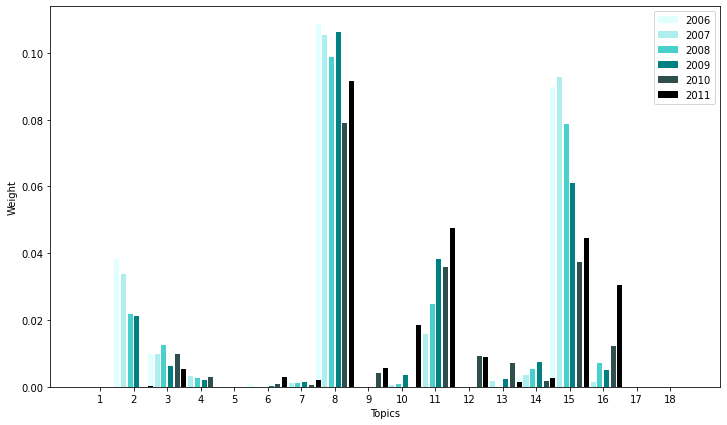

In [58]:
netflix_X = tf_vectorizer.transform(netflix["coDescription"].tolist())
netflix_top = nmf_model.transform(netflix_X)
netflix_top_df = pd.DataFrame(netflix_top).set_index(netflix["reportingDate"])
std_func.graph_netflix(18, netflix_top_df)

In [59]:
pd.set_option('display.max_colwidth', None)
#compare 2011 with 2006
std_func.get_differences(nmf_topics, netflix_top_df.iloc[-1], netflix_top_df.iloc[0]).iloc[:5]

,weight_diff,words
Topic #15,-0.045024,"home, land, property, construction, community, mortgage, estate, real, building, residential"
Topic #2,-0.038165,"store, merchandise, customer, brand, apparel, retail, fiscal, assortment, retailer, footwear"
Topic #11,0.035312,"brand, food, consumer, segment, retail, beverage, restaurant, agreement, ingredient, distribution"
Topic #16,0.030437,"item, statement, registrant, part, stockholder, equity, supplementary, discussion, disclosure, ii"
Topic #10,0.018389,"tax, income, cash, asset, note, net, loss, liability, statement, ended"


- decrease in topic 2(retail/store), 15(real estate/residential)
- increase in topic 10 (finances), 11 (food), 16(common financial report terms)

Analysis: 

Decrease in topic 2(retail/store) and 15(real estate/residential) may be a result of Netflix's change in business model in 2007 which hugely emphasized moving into the video streaming industry and being able to watch content in the comfort of your own home. However, in 2014, the business model is already established so there is a decrease on the emphasis of these topics. 

Topics 11,16, 10 are too general to be interpreted or is irrelevant.

###### NMF - General Electric Analysis

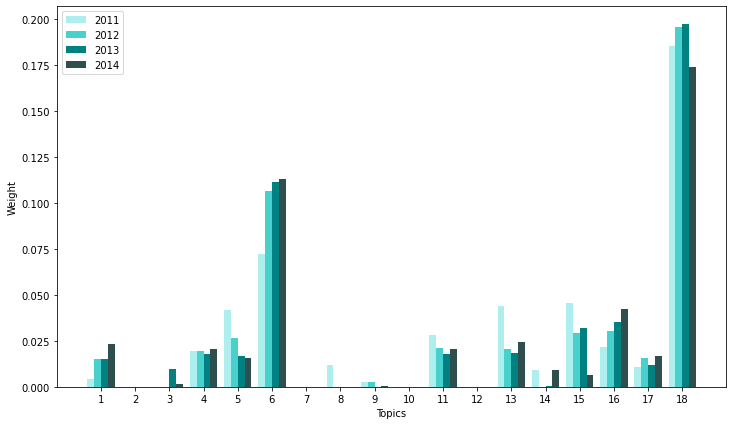

In [60]:
ge_X = tf_vectorizer.transform(ge["coDescription"].tolist())
ge_top = nmf_model.transform(ge_X)
ge_top_df = pd.DataFrame(ge_top).set_index(ge["reportingDate"])
std_func.graph_ge(18, ge_top_df)

In [61]:
# #compare 2014 to 2011 
std_func.get_differences(nmf_topics, ge_top_df.iloc[-1], ge_top_df.iloc[0]).iloc[:5]

,weight_diff,words
Topic #6,0.041036,"gas, oil, natural, drilling, well, pipeline, production, reserve, crude, water"
Topic #15,-0.039207,"home, land, property, construction, community, mortgage, estate, real, building, residential"
Topic #5,-0.026476,"loan, bank, credit, institution, borrower, mortgage, deposit, lending, federal, estate"
Topic #16,0.020692,"item, statement, registrant, part, stockholder, equity, supplementary, discussion, disclosure, ii"
Topic #13,-0.019896,"investment, fund, adviser, portfolio, income, capital, advisor, security, fee, equity"


- decrease in topic 15(real estate/land), 18(aerospace, vehicles)
- increase in topic 5(loan/bank), 6(energy/gas), 16 (financial/analysis)

Analysis: 

Decrease in topic 18(aerospace/vehicles) may indicate that the company is seeing steady growth in the Aerospace section and did not make major changes in their business model. Decrease in topic 15(real estate/residential) may be explained by the planned acquisition of GE Appliances by Electrolux. 

Increase in Topic 5 (loan/bank) may be explained by its acquistion activities where GE Power acquired Alcom and GE Appliances is set to be acquired by Electrolux. Increase in Topic 6(energy/gas) may be explained by GE Power's plan to acquire Alcom. 

##### LSA

The table below illustrates the results produced by the LSA model tuned to generate 20 topics. Each column is a topic identified by the column index and is represented by the top 10 words in the topic by weight. It is interesting to note that the topics here are quite difficult to interpret as there are several different categories of words in each topic.

In [62]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20)
svd_model = pd.DataFrame(svd.fit_transform(filtered_all_X))
lsa_topics = std_func.get_topics(svd,tf_vectorizer, 20)
lsa_topics

C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,customer,store,store,patient,loan,oil,ethanol,gas,president,loan,food,mineral,investment,customer,device,item,item,aircraft,restaurant,customer
1,store,customer,merchandise,clinical,bank,gas,corn,oil,vice,share,brand,mining,fund,merger,semiconductor,registrant,client,vehicle,food,vehicle
2,system,merchandise,loan,fda,patient,ethanol,grain,software,officer,mineral,client,exploration,adviser,client,mineral,estate,segment,aviation,cannabis,investment
3,fiscal,brand,share,drug,fda,natural,distiller,exploration,chief,cannabis,investment,project,client,vehicle,could,investment,solution,system,franchise,property
4,share,apparel,stock,trial,clinical,production,software,client,served,bank,consumer,claim,portfolio,target,exploration,restaurant,registrant,video,franchisees,cannabis
5,brand,retail,brand,cancer,mortgage,exploration,client,property,executive,agreement,restaurant,property,cannabis,opportunity,wafer,real,loan,engine,store,item
6,technology,retailer,common,store,trial,water,gallon,natural,client,exploration,beverage,mine,advisor,transaction,brand,property,statement,entertainment,aircraft,part
7,agreement,fiscal,investment,study,credit,drilling,data,mineral,care,mining,fund,gold,capital,sec,ic,statement,brand,flight,client,drug
8,stock,footwear,apparel,treatment,drug,grain,solution,data,senior,stock,ingredient,ethanol,store,acquisition,memory,device,mining,app,equipment,dealer
9,segment,assortment,retail,medical,estate,mineral,fuel,drilling,food,home,segment,statement,semiconductor,security,laser,entertainment,mineral,online,tax,cancer


###### LSA - Netflix Analysis

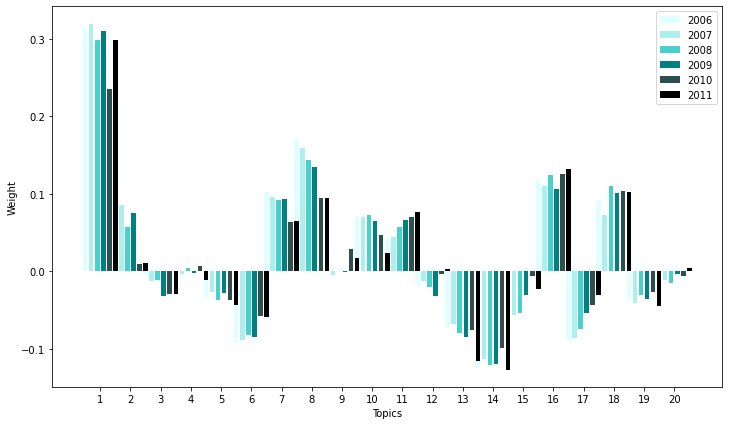

In [63]:
netflix_top = svd.transform(netflix_X)
netflix_top_df = pd.DataFrame(netflix_top).set_index(netflix["reportingDate"])
std_func.graph_netflix(20, netflix_top_df)

In [64]:
#compare 2011 with 2006
std_func.get_differences(lsa_topics,netflix_top_df.iloc[-1], netflix_top_df.iloc[0]).iloc[:5]

,weight_diff,words
Topic #2,-0.085813,"store, customer, merchandise, brand, apparel, retail, retailer, fiscal, footwear, assortment"
Topic #8,-0.075807,"gas, oil, software, exploration, client, property, natural, mineral, data, drilling"
Topic #17,0.057049,"item, client, segment, solution, registrant, loan, statement, brand, mining, mineral"
Topic #10,-0.047472,"loan, share, mineral, cannabis, bank, agreement, exploration, mining, stock, home"
Topic #13,-0.043794,"investment, fund, adviser, client, portfolio, cannabis, advisor, capital, store, semiconductor"


- decrease in topic 2(retail/store) ,8(software, mining), 10(loan, home, commodities, cannabis), 13(investment, cannabis)
- increase in topic 17(mining, financial)

Analysis: 

Decrease in topic 2(retail/store) and 8(software, mining) may be a result of Netflix's change in business model in 2007 which hugely emphasized moving into the video streaming industry and being able to watch content in the comfort of your own home. However, in 2014, the business model is already established so there is a decrease on the emphasis of these topics.

Topics 10, 13, 17 are too general to be interpreted, or is irrelevant.

###### LSA - General Electric Analysis

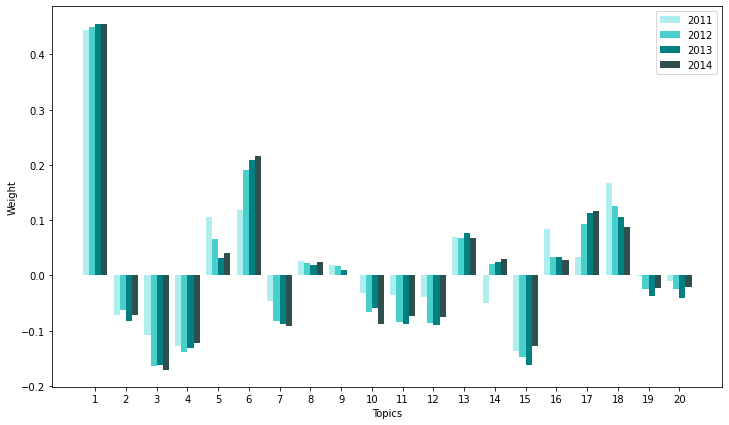

In [65]:
ge_top = svd.transform(ge_X)
ge_top_df = pd.DataFrame(ge_top).set_index(ge["reportingDate"])
std_func.graph_ge(20, ge_top_df)

In [66]:
# compare 2014 to 2011 
std_func.get_differences(lsa_topics,ge_top_df.iloc[-1],ge_top_df.iloc[0]).iloc[:5]

,weight_diff,words
Topic #6,0.098594,"oil, gas, ethanol, natural, production, exploration, water, drilling, grain, mineral"
Topic #17,0.082637,"item, client, segment, solution, registrant, loan, statement, brand, mining, mineral"
Topic #14,0.080336,"customer, merger, client, vehicle, target, opportunity, transaction, sec, acquisition, security"
Topic #18,-0.078389,"aircraft, vehicle, aviation, system, video, engine, entertainment, flight, app, online"
Topic #5,-0.065241,"loan, bank, patient, fda, clinical, mortgage, trial, credit, drug, estate"


- decrease in topic 18(aerospace)
- increase in topic 14(business, acquisition), 17(mining, financial), 19(food/store), 20(vehicle, mineral, partner)

Analysis: 

Decrease in topic 18(aerospace/vehicles) may indicate that the company is seeing steady growth in the Aerospace section and did not make major changes in their business model. 

Increase in Topic 14(business, acquisition) may be explained by its increased acquistion activities where GE Power acquired Alcom and GE Appliances is set to be acquired by Electrolux.

Topic 17, 19, 20 are too general to be interpreted or is irrelevant.

##### LDA

We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3 and achieved the result below. We chose the give our model 9 topics, which has the highest coherence score. If you're interested in the code, see this  [file](https://richardye101.github.io/ubineer_nlp_research/lab?path=mary%2FWeek+10+-+NMF+vs+LDA+vs+LSA.ipynb)

![NMF Coherence](../images/lda_coherence.png)

The table below illustrates the results produced by the LDA model tuned to generate 9 topics. Each column is a topic identified by the column index and is represented by the top 10 words in the topic by weight.

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
count_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=2000)
filtered_all_count_X = count_vectorizer.fit_transform(filtered_data)
count_feature_names = count_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_components=9,random_state=0).fit(filtered_all_count_X)
lda_topics = std_func.get_topics(lda,count_vectorizer, 9)
lda_topics

C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,share,customer,investment,patient,customer,asset,store,loan,property
1,stock,material,security,fda,solution,cash,customer,bank,president
2,agreement,system,tax,clinical,system,note,brand,federal,program
3,common,energy,capital,drug,technology,tax,retail,institution,vice
4,issued,production,income,health,application,fiscal,fiscal,capital,officer
5,date,oil,could,patent,data,statement,distribution,credit,home
6,per,equipment,fund,medical,software,net,believe,rate,revenue
7,price,cost,fee,device,support,september,consumer,september,approximately
8,director,facility,subject,treatment,provide,value,approximately,real,chief
9,exchange,gas,act,approval,network,income,marketing,million,regulation


###### LDA - Netflix Analysis

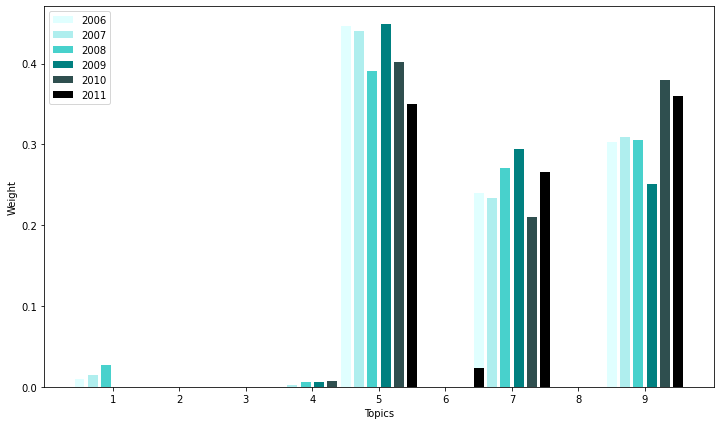

In [68]:
netlfix_X = count_vectorizer.transform(netflix["coDescription"].tolist())
netflix_top = lda.transform(netlfix_X)
netflix_top_df = pd.DataFrame(netflix_top).set_index(netflix["reportingDate"])
std_func.graph_netflix(9, netflix_top_df)

In [69]:
#compare 2011 with 2006
std_func.get_differences(lda_topics,netflix_top_df.iloc[-1], netflix_top_df.iloc[0]).iloc[:5]

,weight_diff,words
Topic #5,-0.097434,"customer, solution, system, technology, application, data, software, support, provide, network"
Topic #9,0.055896,"property, president, program, vice, officer, home, revenue, approximately, chief, regulation"
Topic #7,0.026717,"store, customer, brand, retail, fiscal, distribution, believe, consumer, approximately, marketing"
Topic #6,0.023489,"asset, cash, note, tax, fiscal, statement, net, september, value, income"
Topic #1,-0.009508,"share, stock, agreement, common, issued, date, per, price, director, exchange"


- decrease in topic 1(common financial terms) ,5(software)
- increase in topic 6(common financial terms), 7(retail/branding), 9(managment positions?)

Analysis: 

Decrease in topic 5 (software) may be a result of Netflix's change in business model in 2007 which hugely emphasized moving into the video streaming/software industry. However, in 2014, the business model is already established so there is a decrease on the emphasis of software.

Topics 1,6,7,9 are too general to be interpreted or is irrelevant 

###### LDA - General Electric Analysis

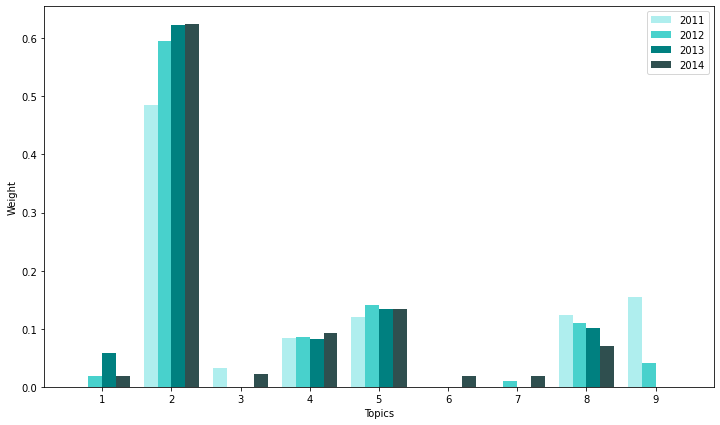

In [70]:
ge_X =  count_vectorizer.transform(ge["coDescription"].tolist())
ge_top = lda.transform(ge_X )
ge_top_df = pd.DataFrame(ge_top).set_index(ge["reportingDate"])
std_func.graph_ge(9, ge_top_df)

In [71]:
# compare 2014 to 2011 
std_func.get_differences(lda_topics,ge_top_df.iloc[-1],ge_top_df.iloc[0]).iloc[:5]

,weight_diff,words
Topic #9,-0.153708,"property, president, program, vice, officer, home, revenue, approximately, chief, regulation"
Topic #2,0.139133,"customer, material, system, energy, production, oil, equipment, cost, facility, gas"
Topic #8,-0.053826,"loan, bank, federal, institution, capital, credit, rate, september, real, million"
Topic #7,0.019148,"store, customer, brand, retail, fiscal, distribution, believe, consumer, approximately, marketing"
Topic #1,0.018867,"share, stock, agreement, common, issued, date, per, price, director, exchange"


- decrease in topic 9(managment positions?)
- increase in topic 7(retail/branding), 8(finance, loan), 1(common financial report terms), 6(positive financial report terms)

Analysis: 
Topics are too general to be interpreted

##### Summary of Topic Modelling
##### General Analysis
In all three models, we observe an interesting decrease in the software topic (Topic 8 in NMF, Topic 7/8 in LSA, and Topic 5 in LDA)  from Netflix from 2006 to 2011. This is surprising because we expected more mentions of software terms after Netflix entered the video streaming market in 2007 and especially in 2011 when Netflix rolled out mobile apps for smartphone users. 

In the NMF and LSA models, we observe an interesting decrease in the aerospace topic (Topic 18 in NMF, Topic 18 in LSA) from GE from 2011 to 2014. This is surprising because GE Aviation was the most profitable sector of GE during these 3 years so we expected more mentions of aerospace terms.

From these observations, we can take away that an increase in the mentions of the words in a topic does not necessarily mean the company business model is moving more in the direction of that topic. Similarly, a decrease in the mentions of the words in a topic does not necessarily mean the company's business model is diverging from that topic. However, we can say that any significant increase or decrease in a topic will give an indication that there has been a change in the company business model with regard to the topic in discussion. 

##### NMF Results
__Netflix__
- decrease in topic 2(retail/store), 15(real estate/residential)
- increase in topic 10 (finances), 11 (food), 16(common financial report terms)

__GE__
- decrease in topic 15(real estate/land), 18(aerospace, vehicles)
- increase in topic 5(loan/bank), 6(energy/gas), 16 (financial/analysis)

##### LDA Results

__Netflix__
- decrease in topic 1(common financial terms) ,5(software)
- increase in topic 6(common financial terms), 7(retail/branding), 9(managment positions?)

__GE__
- decrease in topic 9(managment positions?)
- increase in topic 7(retail/branding), 8(finance, loan), 1(common financial report terms), 6(positive financial report terms)

##### LSA Results

__Netflix__
- decrease in topic 2(retail/store) ,8(software, mining), 10(loan, home, commodities, cannabis), 13(investment, cannabis)
- increase in topic 17(mining, financial)

__GE__
- decrease in topic 18(aerospace)
- increase in topic 14(business, acquisition), 17(mining, financial), 19(food/store), 20(vehicle, mineral, partner)

Topics generated by the NMF model are the easiest to evaluate and are more coherent compared to LDA and LSA. We saw that the LSA model generated topics with mixed categories of words in each topic and contained negative weights which are difficult to interpret.  The LDA model generated many topics with common financial terms that appear in most 10k reports so it did not give meaningful information about each company. Therefore, NMF does the best using this dataset which is expected since NMF usually has higher performance than LDA and LSA when using a small dataset.
